In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Independent datasets
profiles = pd.read_csv('../datasets/profiles.csv')
financials = pd.read_csv('../datasets/financials.csv')
overviews = pd.read_csv('../datasets/overviews.csv')

# Loading datasets

In [153]:
profiles.head(2)

,name,tagline,website,summary,concepts,keywords,sentiment,articles
0,Valera Health,"Your Path to Wellness, Just a Click Away",https://valerahealth.com,"Valera Health, based in New York, is a mental ...",['Comprehensive mental healthcare services for...,"['Mental Health Care', 'Telemedicine', 'Health...","{'sentimentScore': 100, 'cntPositive': 15, 'cn...",[{'contentId': 'ab325015a7bbae7beefc4833b73696...
1,Bestow,"Protecting Life, Simplified",https://bestow.com,Bestow is a Texas-based company that offers fa...,['Offers fast and affordable term life insuran...,"['Insurance', 'Technology', 'Healthcare', 'Fin...","{'sentimentScore': 90, 'cntPositive': 48, 'cnt...",[{'contentId': 'b633176d-6378-46d0-9b15-d2b611...


In [154]:
financials.head(2)

,name,website,investor_count,funding_count,funding_total,funding_last_type,funding_last,funding_last_date,valuation,valuation_date,revenue_year,revenue_total
0,Valera Health,https://valerahealth.com,20.0,8.0,76.32M,Series B - II,9.12M,"April 9, 2024",NaN,NaN,NaN,NaN
1,Bestow,https://bestow.com,8.0,5.0,138.1M,Series C,70M,"December 16, 2020",NaN,NaN,NaN,NaN


In [155]:
overviews.head(2)

,name,website,cb_description,year_founded,mosaic_change,city,region,country,postal
0,Valera Health,https://valerahealth.com,Valera Health operates as a tele-mental health...,2015,-117.0,Brooklyn,New York,United States,11249
1,Bestow,https://bestow.com,Bestow operates as an insurance technology com...,2017,-119.0,Dallas,Texas,United States,75226


# Cleaning the datasets

## Imputation

#### Starting with `profiles.csv`

In [156]:
len(profiles)

8363

In [157]:
profiles.isnull().sum()

name         0
tagline      0
website      0
summary      0
concepts     0
keywords     0
sentiment    0
articles     0
dtype: int64

`profiles.csv` is good to go.

#### Moving on to `financials.csv`

In [158]:
len(financials)

6874

In [159]:
financials.isnull().sum()

name                    0
website                 0
investor_count         63
funding_count         453
funding_total         453
funding_last_type       0
funding_last         1764
funding_last_date      94
valuation            6008
valuation_date       6008
revenue_year         6611
revenue_total        6611
dtype: int64

These are the columns with null values:
1. `investor_count`         63
2. `funding_count`         453
3. `funding_total`         453
4. `funding_last`         1764
5. `funding_last_date`      94
6. `valuation`            6008
7. `valuation_date`       6008
8. `revenue_year`         6611
9. `revenue_total`        6611

Numbers 1 through 4 can be imputed, since the number of missing values in each is less than 25% of the total number of rows of `financials.csv`, which is 6874 rows.

We'll keep 5 as it is, it may be useful.

Numbers 6 through 7 will be dropped from the complete dataset when we integrate the data, but will be copied into two seperate datasets, one with startups with complete valuation information, and another with startups with complete valuation information.

In [160]:
def print_stats(mean, median, mode, skew):
    print(f'Mean: {float(mean):.2f}')
    print(f'Median: {float(median):.2f}')
    print(f'Mode: {float(mode):.2f}')
    print(f'Skew: {float(skew):.2f}')

##### 1. `investor_count`

Mean: 10.12
Median: 9.00
Mode: 1.00
Skew: 1.65


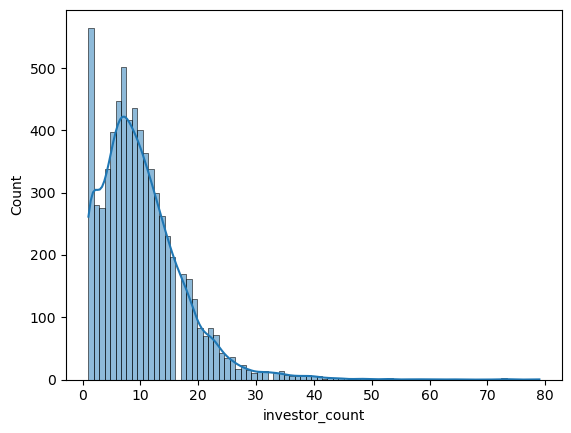

In [161]:
investor_count_mean = financials['investor_count'].mean(skipna=True)
investor_count_median = financials['investor_count'].median(skipna=True)
investor_count_mode = financials['investor_count'].mode()
investor_count_skew = financials['investor_count'].skew(skipna=True)

print_stats(investor_count_mean, investor_count_median, investor_count_mode, investor_count_skew)

sns.histplot(financials['investor_count'], kde=True)
plt.show()

Large positive skew with many values at 1, so we will use median as an imputation value.

In [162]:
financials['investor_count'].fillna(investor_count_median, inplace=True)
financials['investor_count'].isnull().sum()

0

##### 2. `funding_count`

Mean: 5.31
Median: 5.00
Mode: 3.00
Skew: 1.54


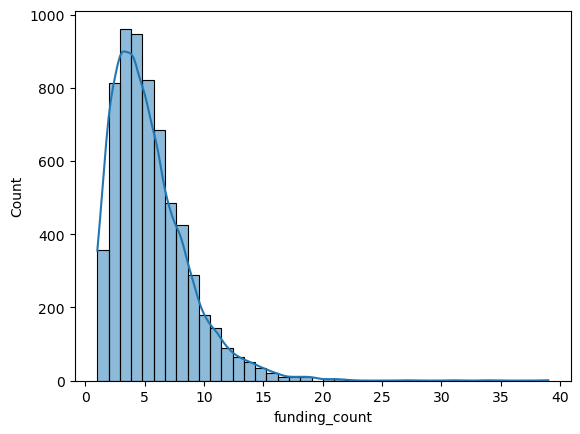

In [163]:
funding_count_mean = financials['funding_count'].mean(skipna=True)
funding_count_median = financials['funding_count'].median(skipna=True)
funding_count_mode = financials['funding_count'].mode()
funding_count_skew = financials['funding_count'].skew(skipna=True)

print_stats(funding_count_mean, funding_count_median, funding_count_mode, funding_count_skew)

sns.histplot(financials['funding_count'], kde=True, bins=40)
plt.show()

Large positive skew with many values at 3, so we will use median as an imputation value.

In [164]:
financials['funding_count'].fillna(funding_count_median, inplace=True)
financials['funding_count'].isnull().sum()

0

##### 3. `funding_total`

Lets convert `funding_total` to have the unit millions of dollars.

In [165]:
financials['funding_total_numeric_millions'] = (
    financials['funding_total'].astype(str)
    .str.replace('M', '', regex=False)
    .str.replace('B', '', regex=False)
    .str.replace('K', '', regex=False)
    .astype(float)
    * financials['funding_total'].apply(
    lambda x: 1 if 'M' in str(x) else 1000 if 'B' in str(x) else (1/1000) if 'K' in str(x) else 1)
)
financials['funding_total_numeric_millions']

0        76.32
1       138.10
2        99.00
3        14.70
4       390.50
         ...  
6869      0.05
6870       NaN
6871       NaN
6872       NaN
6873    390.50
Name: funding_total_numeric_millions, Length: 6874, dtype: float64

Mean: 106.18
Median: 26.00
Mode: 0.02
Skew: 32.32


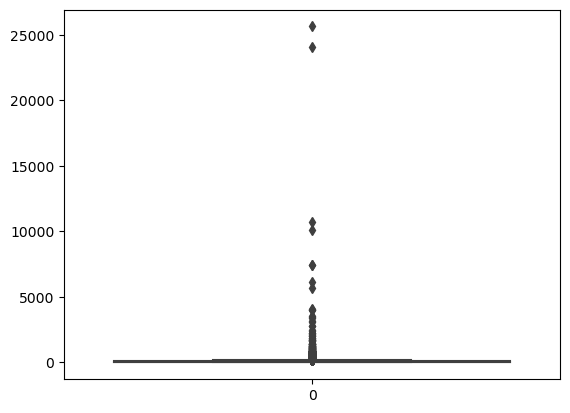

In [166]:
funding_total_mean = financials['funding_total_numeric_millions'].mean(skipna=True)
funding_total_median = financials['funding_total_numeric_millions'].median(skipna=True)
funding_total_mode = financials['funding_total_numeric_millions'].mode()
funding_total_skew = financials['funding_total_numeric_millions'].skew(skipna=True)

print_stats(funding_total_mean, funding_total_median, funding_total_mode, funding_total_skew)

sns.boxplot(financials['funding_total_numeric_millions'])
plt.show()

We can see many large outliers, so we will use median as an imputation value.

In [167]:
financials['funding_total_numeric_millions'].fillna(funding_total_median, inplace=True)
financials['funding_total_numeric_millions'].isnull().sum()

0

##### 4. `funding_last`

Lets convert `funding_last` to have the unit millions of dollars.

In [168]:
financials['funding_last_numeric_millions'] = (
    financials['funding_last'].astype(str)
    .str.replace(',', '', regex=False)
    .str.replace('M', '', regex=False)
    .str.replace('B', '', regex=False)
    .str.replace('K', '', regex=False)
    .astype(float)
    * financials['funding_last'].apply(
    lambda x: 1 if 'M' in str(x) else 1000 if 'B' in str(x) else (1/1000) if 'K' in str(x) else 1)
)
financials['funding_last_numeric_millions']

0        9.12
1       70.00
2       75.00
3       10.00
4        7.77
        ...  
6869      NaN
6870      NaN
6871      NaN
6872      NaN
6873     7.77
Name: funding_last_numeric_millions, Length: 6874, dtype: float64

Mean: 40.71
Median: 13.00
Mode: 20.00
Skew: 25.90


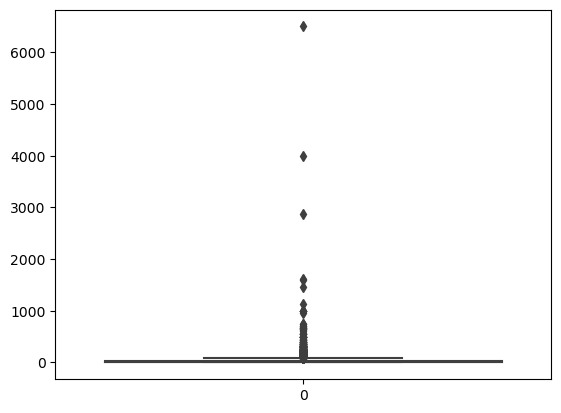

In [169]:
funding_last_mean = financials['funding_last_numeric_millions'].mean(skipna=True)
funding_last_median = financials['funding_last_numeric_millions'].median(skipna=True)
funding_last_mode = financials['funding_last_numeric_millions'].mode()
funding_last_skew = financials['funding_last_numeric_millions'].skew(skipna=True)

print_stats(funding_last_mean, funding_last_median, funding_last_mode, funding_last_skew)

sns.boxplot(financials['funding_last_numeric_millions'])
plt.show()

We can see many large outliers, so we will use median as an imputation value.

In [170]:
financials['funding_last_numeric_millions'].fillna(funding_last_median, inplace=True)
financials['funding_last_numeric_millions'].isnull().sum()

0

Lets drop the old `funding_total` and `funding_last` columns.

In [171]:
financials.drop(['funding_total', 'funding_last'], axis=1, inplace=True)
financials.head()

,name,website,investor_count,funding_count,funding_last_type,funding_last_date,valuation,valuation_date,revenue_year,revenue_total,funding_total_numeric_millions,funding_last_numeric_millions
0,Valera Health,https://valerahealth.com,20.0,8.0,Series B - II,"April 9, 2024",NaN,NaN,NaN,NaN,76.32,9.12
1,Bestow,https://bestow.com,8.0,5.0,Series C,"December 16, 2020",NaN,NaN,NaN,NaN,138.10,70.00
2,PlainID,https://plainid.com,10.0,5.0,Series C,"December 21, 2021",$48M,December 2020,NaN,NaN,99.00,75.00
3,Snapcart,https://snapcart.global,9.0,4.0,Series A,"October 25, 2017",NaN,NaN,NaN,NaN,14.70,10.00
4,Slice,https://sliceit.com,36.0,21.0,Debt - VIII,"July 19, 2024","$1,800M",June 2022,NaN,NaN,390.50,7.77


##### 6. `valuation`

In [172]:
financials['valuation_numeric_millions'] = (
    financials['valuation'].astype(str)
    .str.replace(',', '', regex=False)
    .str.replace('M', '', regex=False)
    .str.replace('B', '', regex=False)
    .str.replace('K', '', regex=False)
    .str.replace('$', '', regex=False)
    .astype(float)
    * financials['valuation'].apply(
    lambda x: 1 if 'M' in str(x) else 1000 if 'B' in str(x) else (1/1000) if 'K' in str(x) else 1)
)

financials['valuation_numeric_millions'].isnull().sum()
financials.head()

,name,website,investor_count,funding_count,funding_last_type,funding_last_date,valuation,valuation_date,revenue_year,revenue_total,funding_total_numeric_millions,funding_last_numeric_millions,valuation_numeric_millions
0,Valera Health,https://valerahealth.com,20.0,8.0,Series B - II,"April 9, 2024",NaN,NaN,NaN,NaN,76.32,9.12,NaN
1,Bestow,https://bestow.com,8.0,5.0,Series C,"December 16, 2020",NaN,NaN,NaN,NaN,138.10,70.00,NaN
2,PlainID,https://plainid.com,10.0,5.0,Series C,"December 21, 2021",$48M,December 2020,NaN,NaN,99.00,75.00,48.0
3,Snapcart,https://snapcart.global,9.0,4.0,Series A,"October 25, 2017",NaN,NaN,NaN,NaN,14.70,10.00,NaN
4,Slice,https://sliceit.com,36.0,21.0,Debt - VIII,"July 19, 2024","$1,800M",June 2022,NaN,NaN,390.50,7.77,1800.0


In [173]:
financials.drop(['valuation'], axis=1, inplace=True)
financials.head()

,name,website,investor_count,funding_count,funding_last_type,funding_last_date,valuation_date,revenue_year,revenue_total,funding_total_numeric_millions,funding_last_numeric_millions,valuation_numeric_millions
0,Valera Health,https://valerahealth.com,20.0,8.0,Series B - II,"April 9, 2024",NaN,NaN,NaN,76.32,9.12,NaN
1,Bestow,https://bestow.com,8.0,5.0,Series C,"December 16, 2020",NaN,NaN,NaN,138.10,70.00,NaN
2,PlainID,https://plainid.com,10.0,5.0,Series C,"December 21, 2021",December 2020,NaN,NaN,99.00,75.00,48.0
3,Snapcart,https://snapcart.global,9.0,4.0,Series A,"October 25, 2017",NaN,NaN,NaN,14.70,10.00,NaN
4,Slice,https://sliceit.com,36.0,21.0,Debt - VIII,"July 19, 2024",June 2022,NaN,NaN,390.50,7.77,1800.0


##### 9. `revenue_total`

In [174]:
financials['revenue_total_numeric_millions'] = (
    financials['revenue_total'].astype(str)
    .str.replace(',', '', regex=False)
    .str.replace('M', '', regex=False)
    .str.replace('B', '', regex=False)
    .str.replace('K', '', regex=False)
    .str.replace('T', '', regex=False)
    .astype(float)
    * financials['revenue_total'].apply(
    lambda x: 1 if 'M' in str(x) else 1000 if 'B' in str(x) else (1/1000) if 'K' in str(x) else 1000000 if 'T' in str(x) else 1)
)

financials['revenue_total_numeric_millions'].isnull().sum()
financials.head()

,name,website,investor_count,funding_count,funding_last_type,funding_last_date,valuation_date,revenue_year,revenue_total,funding_total_numeric_millions,funding_last_numeric_millions,valuation_numeric_millions,revenue_total_numeric_millions
0,Valera Health,https://valerahealth.com,20.0,8.0,Series B - II,"April 9, 2024",NaN,NaN,NaN,76.32,9.12,NaN,NaN
1,Bestow,https://bestow.com,8.0,5.0,Series C,"December 16, 2020",NaN,NaN,NaN,138.10,70.00,NaN,NaN
2,PlainID,https://plainid.com,10.0,5.0,Series C,"December 21, 2021",December 2020,NaN,NaN,99.00,75.00,48.0,NaN
3,Snapcart,https://snapcart.global,9.0,4.0,Series A,"October 25, 2017",NaN,NaN,NaN,14.70,10.00,NaN,NaN
4,Slice,https://sliceit.com,36.0,21.0,Debt - VIII,"July 19, 2024",June 2022,NaN,NaN,390.50,7.77,1800.0,NaN


In [175]:
financials.drop(['revenue_total'], axis=1, inplace=True)
financials.head()

,name,website,investor_count,funding_count,funding_last_type,funding_last_date,valuation_date,revenue_year,funding_total_numeric_millions,funding_last_numeric_millions,valuation_numeric_millions,revenue_total_numeric_millions
0,Valera Health,https://valerahealth.com,20.0,8.0,Series B - II,"April 9, 2024",NaN,NaN,76.32,9.12,NaN,NaN
1,Bestow,https://bestow.com,8.0,5.0,Series C,"December 16, 2020",NaN,NaN,138.10,70.00,NaN,NaN
2,PlainID,https://plainid.com,10.0,5.0,Series C,"December 21, 2021",December 2020,NaN,99.00,75.00,48.0,NaN
3,Snapcart,https://snapcart.global,9.0,4.0,Series A,"October 25, 2017",NaN,NaN,14.70,10.00,NaN,NaN
4,Slice,https://sliceit.com,36.0,21.0,Debt - VIII,"July 19, 2024",June 2022,NaN,390.50,7.77,1800.0,NaN


#### Now on to `overviews.csv`

In [190]:
len(overviews)

7246

In [191]:
overviews.isnull().sum()

name                 1
website              1
cb_description      18
year_founded       569
mosaic_change     1784
city               557
region            2011
country             68
postal             835
dtype: int64

Lets drop the row with a null name and website.

In [192]:
overviews = overviews.dropna(subset=['name'])

In [193]:
overviews.isnull().sum()

name                 0
website              0
cb_description      17
year_founded       568
mosaic_change     1783
city               556
region            2010
country             67
postal             834
dtype: int64

We can also drop the rows without descriptions.

In [195]:
overviews = overviews.dropna(subset=['cb_description'])

In [196]:
overviews.isnull().sum()

name                 0
website              0
cb_description       0
year_founded       551
mosaic_change     1766
city               539
region            1993
country             50
postal             817
dtype: int64

Next, we will drop the rows without countries.

In [197]:
overviews = overviews.dropna(subset=['country'])

In [198]:
overviews.isnull().sum()

name                 0
website              0
cb_description       0
year_founded       502
mosaic_change     1716
city               489
region            1943
country              0
postal             767
dtype: int64

It is okay for `year_founded`, `city`, `region`, and `postal` to have missing values. The final column to impute is `mosaic_change`.

Mean: -19.12
Median: -38.00
Mode: -41.00
Skew: 0.97


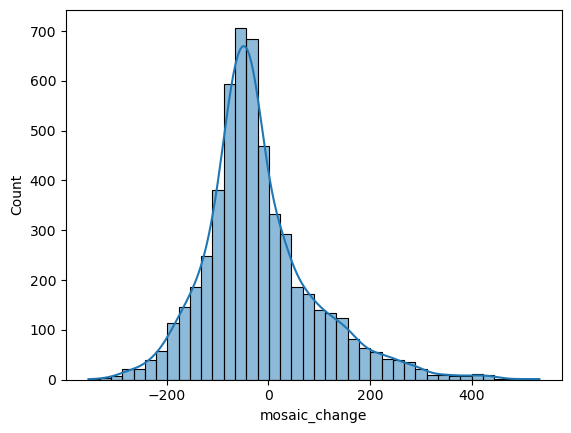

In [201]:
mosaic_change_mean = overviews['mosaic_change'].mean(skipna=True)
mosaic_change_median = overviews['mosaic_change'].median(skipna=True)
mosaic_change_mode = overviews['mosaic_change'].mode()
mosaic_change_skew = overviews['mosaic_change'].skew(skipna=True)

print_stats(mosaic_change_mean, mosaic_change_median, mosaic_change_mode, mosaic_change_skew)

sns.histplot(overviews['mosaic_change'], kde=True, bins=40)
plt.show()

We can see scores are moderately skewed, so we will be using the median.

In [202]:
overviews['mosaic_change'].fillna(mosaic_change_median, inplace=True)
overviews['mosaic_change'].isnull().sum()

0

In [205]:
overviews.isnull().sum()

name                 0
website              0
cb_description       0
year_founded       502
mosaic_change        0
city               489
region            1943
country              0
postal             767
dtype: int64

## Type conversion

We will leave the types in `profiles.csv` as objects because they are mostly strings and some contain lists and JSON objects.

In [207]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8363 entries, 0 to 8362
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       8363 non-null   object
 1   tagline    8363 non-null   object
 2   website    8363 non-null   object
 3   summary    8363 non-null   object
 4   concepts   8363 non-null   object
 5   keywords   8363 non-null   object
 6   sentiment  8363 non-null   object
 7   articles   8363 non-null   object
dtypes: object(8)
memory usage: 522.8+ KB


##### 1. Int types

In [176]:
l = ['investor_count', 'funding_count']
for i in l:
    financials[i] = pd.to_numeric(financials[i], errors='coerce').astype('Int64')

In [177]:
financials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6874 entries, 0 to 6873
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            6874 non-null   object 
 1   website                         6874 non-null   object 
 2   investor_count                  6874 non-null   Int64  
 3   funding_count                   6874 non-null   Int64  
 4   funding_last_type               6874 non-null   object 
 5   funding_last_date               6780 non-null   object 
 6   valuation_date                  866 non-null    object 
 7   revenue_year                    263 non-null    float64
 8   funding_total_numeric_millions  6874 non-null   float64
 9   funding_last_numeric_millions   6874 non-null   float64
 10  valuation_numeric_millions      866 non-null    float64
 11  revenue_total_numeric_millions  263 non-null    float64
dtypes: Int64(2), float64(5), object(5)

##### 2. Categorical types

In [178]:
l = ['funding_last_type']
for i in l:
    financials[i] = financials[i].astype('category')

In [179]:
financials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6874 entries, 0 to 6873
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   name                            6874 non-null   object  
 1   website                         6874 non-null   object  
 2   investor_count                  6874 non-null   Int64   
 3   funding_count                   6874 non-null   Int64   
 4   funding_last_type               6874 non-null   category
 5   funding_last_date               6780 non-null   object  
 6   valuation_date                  866 non-null    object  
 7   revenue_year                    263 non-null    float64 
 8   funding_total_numeric_millions  6874 non-null   float64 
 9   funding_last_numeric_millions   6874 non-null   float64 
 10  valuation_numeric_millions      866 non-null    float64 
 11  revenue_total_numeric_millions  263 non-null    float64 
dtypes: Int64(2), categor

In [210]:
l = ['city', 'region', 'country', 'postal']
for i in l:
    overviews[i] = overviews[i].astype('category')

In [211]:
overviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7178 entries, 0 to 7245
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   name            7178 non-null   object  
 1   website         7178 non-null   object  
 2   cb_description  7178 non-null   object  
 3   year_founded    6676 non-null   object  
 4   mosaic_change   7178 non-null   float64 
 5   city            6689 non-null   category
 6   region          5235 non-null   category
 7   country         7178 non-null   category
 8   postal          6411 non-null   category
dtypes: category(4), float64(1), object(4)
memory usage: 526.9+ KB


##### 4. Datetime types (formatted as string in object type)

In [184]:
financials['funding_last_date'] = pd.to_datetime(financials['funding_last_date'], format='%B %d, %Y', errors='coerce')
financials['valuation_date'] = pd.to_datetime(financials['valuation_date'], format='%B %Y', errors='coerce')
financials['revenue_year'] = pd.to_datetime(financials['revenue_year'], format='%Y', errors='coerce')

financials['funding_last_date'] = financials['funding_last_date'].dt.strftime('%Y-%m-%d')
financials['valuation_date'] = financials['valuation_date'].dt.strftime('%Y-%m')
financials['revenue_year'] = financials['revenue_year'].dt.strftime('%Y') 

In [185]:
financials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6874 entries, 0 to 6873
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   name                            6874 non-null   object  
 1   website                         6874 non-null   object  
 2   investor_count                  6874 non-null   Int64   
 3   funding_count                   6874 non-null   Int64   
 4   funding_last_type               6874 non-null   category
 5   funding_last_date               6780 non-null   object  
 6   valuation_date                  866 non-null    object  
 7   revenue_year                    263 non-null    object  
 8   funding_total_numeric_millions  6874 non-null   float64 
 9   funding_last_numeric_millions   6874 non-null   float64 
 10  valuation_numeric_millions      866 non-null    float64 
 11  revenue_total_numeric_millions  263 non-null    float64 
dtypes: Int64(2), categor

In [214]:
overviews['year_founded'] = pd.to_datetime(overviews['year_founded'], format='%Y', errors='coerce')

overviews['year_founded'] = overviews['year_founded'].dt.strftime('%Y')

In [215]:
overviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7178 entries, 0 to 7245
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   name            7178 non-null   object  
 1   website         7178 non-null   object  
 2   cb_description  7178 non-null   object  
 3   year_founded    6675 non-null   object  
 4   mosaic_change   7178 non-null   float64 
 5   city            6689 non-null   category
 6   region          5235 non-null   category
 7   country         7178 non-null   category
 8   postal          6411 non-null   category
dtypes: category(4), float64(1), object(4)
memory usage: 526.9+ KB


# Summary of cleaned datasets

In [225]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8363 entries, 0 to 8362
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       8363 non-null   object
 1   tagline    8363 non-null   object
 2   website    8363 non-null   object
 3   summary    8363 non-null   object
 4   concepts   8363 non-null   object
 5   keywords   8363 non-null   object
 6   sentiment  8363 non-null   object
 7   articles   8363 non-null   object
dtypes: object(8)
memory usage: 522.8+ KB


In [218]:
profiles.head(3)

,name,tagline,website,summary,concepts,keywords,sentiment,articles
0,Valera Health,"Your Path to Wellness, Just a Click Away",https://valerahealth.com,"Valera Health, based in New York, is a mental ...",['Comprehensive mental healthcare services for...,"['Mental Health Care', 'Telemedicine', 'Health...","{'sentimentScore': 100, 'cntPositive': 15, 'cn...",[{'contentId': 'ab325015a7bbae7beefc4833b73696...
1,Bestow,"Protecting Life, Simplified",https://bestow.com,Bestow is a Texas-based company that offers fa...,['Offers fast and affordable term life insuran...,"['Insurance', 'Technology', 'Healthcare', 'Fin...","{'sentimentScore': 90, 'cntPositive': 48, 'cnt...",[{'contentId': 'b633176d-6378-46d0-9b15-d2b611...
2,Mediktor,"Revolutionizing Healthcare, One AI-Powered Dia...",https://mediktor.com,Mediktor is a company based in Catalonia that ...,['Specializes in AI-driven healthcare technolo...,"['Healthcare Technology', 'Artificial Intellig...","{'sentimentScore': 100, 'cntPositive': 8, 'cnt...",[{'contentId': 'cb5d965c-68e4-4f44-a4e9-07ac8d...


In [224]:
financials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6874 entries, 0 to 6873
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   name                            6874 non-null   object  
 1   website                         6874 non-null   object  
 2   investor_count                  6874 non-null   Int64   
 3   funding_count                   6874 non-null   Int64   
 4   funding_last_type               6874 non-null   category
 5   funding_last_date               6780 non-null   object  
 6   valuation_date                  866 non-null    object  
 7   revenue_year                    263 non-null    object  
 8   funding_total_numeric_millions  6874 non-null   float64 
 9   funding_last_numeric_millions   6874 non-null   float64 
 10  valuation_numeric_millions      866 non-null    float64 
 11  revenue_total_numeric_millions  263 non-null    float64 
dtypes: Int64(2), categor

In [220]:
financials.head(3)

,name,website,investor_count,funding_count,funding_last_type,funding_last_date,valuation_date,revenue_year,funding_total_numeric_millions,funding_last_numeric_millions,valuation_numeric_millions,revenue_total_numeric_millions
0,Valera Health,https://valerahealth.com,20,8,Series B - II,2024-04-09,NaN,NaN,76.32,9.12,NaN,NaN
1,Bestow,https://bestow.com,8,5,Series C,2020-12-16,NaN,NaN,138.10,70.00,NaN,NaN
2,PlainID,https://plainid.com,10,5,Series C,2021-12-21,2020-12,NaN,99.00,75.00,48.0,NaN


In [223]:
overviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7178 entries, 0 to 7245
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   name            7178 non-null   object  
 1   website         7178 non-null   object  
 2   cb_description  7178 non-null   object  
 3   year_founded    6675 non-null   object  
 4   mosaic_change   7178 non-null   float64 
 5   city            6689 non-null   category
 6   region          5235 non-null   category
 7   country         7178 non-null   category
 8   postal          6411 non-null   category
dtypes: category(4), float64(1), object(4)
memory usage: 526.9+ KB


In [222]:
overviews.head(3)

,name,website,cb_description,year_founded,mosaic_change,city,region,country,postal
0,Valera Health,https://valerahealth.com,Valera Health operates as a tele-mental health...,2015,-117.0,Brooklyn,New York,United States,11249
1,Bestow,https://bestow.com,Bestow operates as an insurance technology com...,2017,-119.0,Dallas,Texas,United States,75226
3,PlainID,https://plainid.com,PlainID is an Identity Security Posture Manage...,2014,-120.0,Tel Aviv,NaN,Israel,6789139


As mentioned earlier, seperate tables will be made for startups with revenue and valuation data. Then, those columns will be dropped from the primary table.

# Write out cleaned datasets into new .csv files

In [227]:
profiles.to_csv('../datasets/clean-profiles.csv', index=False)
financials.to_csv('../datasets/clean-financials.csv', index=False)
overviews.to_csv('../datasets/clean-overviews.csv', index=False)